Table of Contents:

1.   Installation of Necessary Packages

2.   Reviews Preprocessing and Cleaning

3.   Story Generation and Visualization from reviews

4.   Extracting Features from Cleaned reviews

5.   Model Building: Sentiment Analysis






### INSTALLATION OF PACKAGES  
1. VISULAIZATION LIBRARIES FOR THE ANALYSIS
- Word cloud
- Text Blob
- Plotly

In [1]:
%pip install wordcloud


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -qq -U textblob

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -qq cufflinks

Note: you may need to restart the kernel to use updated packages.


INSTALL AND APPLY ALGORITHMS LATER IN THE END
- XGBOOST
- LIGHTGBM
- CATBOOST

In [4]:
# import basic libraries
import pandas as pd 
import numpy as np 

# import progress bar module
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook


# import visualization tools
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

# import text preprocessing tools
import nltk
import re
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# import sklearn preprocessing packages and pipelines
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline

# import sklearn model_selection modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

# import sklearn models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# import sklearn metrics libraries
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import other libraries
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter

# initiate random_seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# initialize our fig size
rcParams['figure.figsize'] = 12, 10

LOAD THE REVIEW CSV FILES 

In [5]:
# load and check the first five rows of the csv
review_df = pd.read_csv('./Data/reviews.csv')
review_df.head()


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Meditation Relaxing Music Inspiration,https://play-lh.googleusercontent.com/a-/AFdZu...,Useless and frustrated app in terms of custome...,1,0,2.4.47,2022-07-21 09:28:55,NaN,NaN,most_relevant,com.flutterwave.flybarter
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,mask angel,https://play-lh.googleusercontent.com/a-/AFdZu...,"Scammers, the lot of them. Don't download this...",1,17,2.4.45,2022-06-29 08:59:48,"Hello, we are so sorry for the inconvenience. ...",2022-07-01 16:31:33,most_relevant,com.flutterwave.flybarter
2,4c55f499-eb1b-4aec-ab8e-858902b60992,Fred Ronald,https://play-lh.googleusercontent.com/a/AItbvm...,"My experience hasn't been good,the app keeps l...",1,3,2.4.45,2022-07-20 18:57:04,"Hi Victor, this must have been a frustrating e...",2022-07-21 04:22:29,most_relevant,com.flutterwave.flybarter
3,db8cc164-107b-4024-81df-738ec37fd20d,Sweet Love,https://play-lh.googleusercontent.com/a/AItbvm...,Very annoying app ever. I signed up account an...,1,8,2.4.44,2022-06-04 22:29:25,"Hello, We apologise for the inconvenience caus...",2022-06-09 06:00:42,most_relevant,com.flutterwave.flybarter
4,52b105b4-77e0-4018-87dc-e66c9625790d,Prince Simeon.A,https://play-lh.googleusercontent.com/a-/AFdZu...,I thought the experience would be an awesome o...,1,1,2.4.44,2022-06-03 20:53:11,"Hi Prince, we are so sorry about your experien...",2022-06-09 04:30:57,most_relevant,com.flutterwave.flybarter


In [6]:
print('The review dataset has {} features and {} observations'.format(review_df.shape[1], review_df.shape[0]))

The review dataset has 12 features and 21932 observations


In [7]:
review_df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'sortOrder', 'appId'],
      dtype='object')

<h3>Dataset Details</h3>


<p>Description of columns in the file: </p>

<li>reviewID - ID of the reviewer, e.g. 52b105b4-77e0-4018-87dc-e66c9625790d </li>
<li>userName - ID of the product, e.g.Prince Simeon.A </li>
<li>userImage - image link of the reveiwer</li>
<li>content - sentiment/text of the reviewer</li>
<li>score - the rating score from the reviewer (1-5)</li>
<li>thumbsUpCount - The number of individuals that like or share the same idea with the review texts</li>
<li>reviewCreatedVersion - The version of the review </li>
<li>at - datetime of the review (str)</li>
<li>replyContent - text/reply of the developer </li>
<li>repliedAt - datetime the sentiment is replied to  (str)</li>
<li>reviewText - text of the review</li>
<li>sortOrder - the order of sorting the review</li>
<li>appId - id of the app</li>

In [8]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21932 entries, 0 to 21931
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              21932 non-null  object
 1   userName              21932 non-null  object
 2   userImage             21932 non-null  object
 3   content               21932 non-null  object
 4   score                 21932 non-null  int64 
 5   thumbsUpCount         21932 non-null  int64 
 6   reviewCreatedVersion  19025 non-null  object
 7   at                    21932 non-null  object
 8   replyContent          13429 non-null  object
 9   repliedAt             13429 non-null  object
 10  sortOrder             21932 non-null  object
 11  appId                 21932 non-null  object
dtypes: int64(2), object(10)
memory usage: 2.0+ MB


### Reviews Preprocessing and cleaning
We are going to do a lot of preprocessing before sending the reviews to the model. Let's go step by step.

In [37]:
# make a copy of the review_df for preprocessing
# change the columns text and replace the space with dash
preprocess_review = review_df.copy()
columns = [col.replace(' ', '_').lower() for col in preprocess_review.columns]
preprocess_review.columns = columns
preprocess_review.head()

,reviewid,username,userimage,content,score,thumbsupcount,reviewcreatedversion,at,replycontent,repliedat,sortorder,appid
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Meditation Relaxing Music Inspiration,https://play-lh.googleusercontent.com/a-/AFdZu...,Useless and frustrated app in terms of custome...,1,0,2.4.47,2022-07-21 09:28:55,NaN,NaN,most_relevant,com.flutterwave.flybarter
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,mask angel,https://play-lh.googleusercontent.com/a-/AFdZu...,"Scammers, the lot of them. Don't download this...",1,17,2.4.45,2022-06-29 08:59:48,"Hello, we are so sorry for the inconvenience. ...",2022-07-01 16:31:33,most_relevant,com.flutterwave.flybarter
2,4c55f499-eb1b-4aec-ab8e-858902b60992,Fred Ronald,https://play-lh.googleusercontent.com/a/AItbvm...,"My experience hasn't been good,the app keeps l...",1,3,2.4.45,2022-07-20 18:57:04,"Hi Victor, this must have been a frustrating e...",2022-07-21 04:22:29,most_relevant,com.flutterwave.flybarter
3,db8cc164-107b-4024-81df-738ec37fd20d,Sweet Love,https://play-lh.googleusercontent.com/a/AItbvm...,Very annoying app ever. I signed up account an...,1,8,2.4.44,2022-06-04 22:29:25,"Hello, We apologise for the inconvenience caus...",2022-06-09 06:00:42,most_relevant,com.flutterwave.flybarter
4,52b105b4-77e0-4018-87dc-e66c9625790d,Prince Simeon.A,https://play-lh.googleusercontent.com/a-/AFdZu...,I thought the experience would be an awesome o...,1,1,2.4.44,2022-06-03 20:53:11,"Hi Prince, we are so sorry about your experien...",2022-06-09 04:30:57,most_relevant,com.flutterwave.flybarter


In [38]:
# check the null value
preprocess_review.isnull().sum()

reviewid                   0
username                   0
userimage                  0
content                    0
score                      0
thumbsupcount              0
reviewcreatedversion    2907
at                         0
replycontent            8503
repliedat               8503
sortorder                  0
appid                      0
dtype: int64

In [39]:
# Get the null_value columns 
null_columns = preprocess_review.columns[preprocess_review.isna().any()].to_list()
null_columns

['reviewcreatedversion', 'replycontent', 'repliedat']

In [40]:
#drop the null value columns as it is not really useful in our analysis and also classify the sentiment
# drop the user image
preprocess_review.drop(null_columns, axis = 1, inplace=True)
preprocess_review.drop('userimage', axis = 1, inplace=True)
preprocess_review.head()

,reviewid,username,content,score,thumbsupcount,at,sortorder,appid
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Meditation Relaxing Music Inspiration,Useless and frustrated app in terms of custome...,1,0,2022-07-21 09:28:55,most_relevant,com.flutterwave.flybarter
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,mask angel,"Scammers, the lot of them. Don't download this...",1,17,2022-06-29 08:59:48,most_relevant,com.flutterwave.flybarter
2,4c55f499-eb1b-4aec-ab8e-858902b60992,Fred Ronald,"My experience hasn't been good,the app keeps l...",1,3,2022-07-20 18:57:04,most_relevant,com.flutterwave.flybarter
3,db8cc164-107b-4024-81df-738ec37fd20d,Sweet Love,Very annoying app ever. I signed up account an...,1,8,2022-06-04 22:29:25,most_relevant,com.flutterwave.flybarter
4,52b105b4-77e0-4018-87dc-e66c9625790d,Prince Simeon.A,I thought the experience would be an awesome o...,1,1,2022-06-03 20:53:11,most_relevant,com.flutterwave.flybarter


In [41]:
# check the distribution of each rating score
rating_count = preprocess_review.score.value_counts()
rating_count

3    6544
1    4000
5    4000
4    3882
2    3506
Name: score, dtype: int64

<AxesSubplot:title={'center':'The distribution of rating scores of the reviews'}, xlabel='Rating', ylabel='Frequency'>

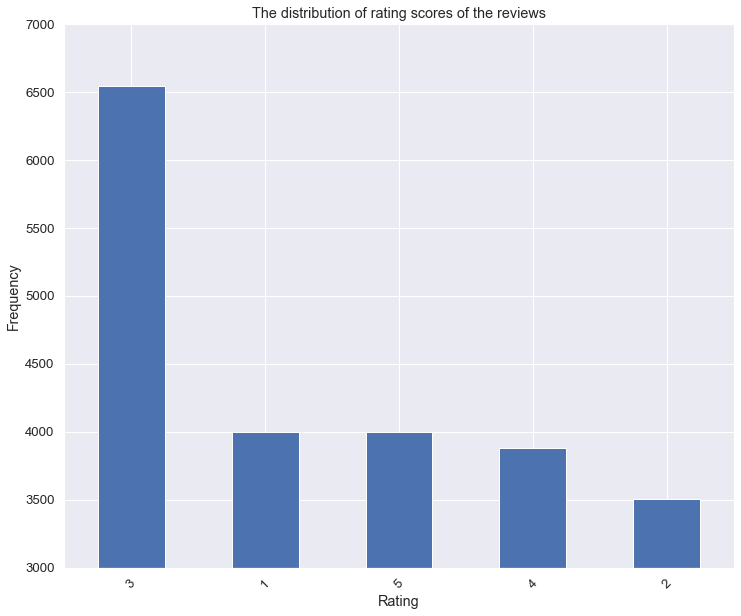

In [42]:
# create a bar plot of the ratings distribution
rating_count.plot(
kind = 'bar',
rot = 45,
ylim = (3000, 7000),
title = 'The distribution of rating scores of the reviews',
ylabel = 'Frequency',
xlabel= 'Rating'
)

### Create sentiment column
<p>This is an important preprocessing phase, we will create column (sentiment of review) based on the rating score. If the score is greater than 3, we take it as positive, less than 3 taken as negative, equal to 3, we take as Neutral sentiment.</p>

In [43]:
# function to create sentiment
def sentiment(row):
    
    '''This function returns sentiment value based on the scores from the user'''
    
    if row['score'] == 3.0:
        val = 'Neutral'
    elif row['score'] == 1.0 or row['score'] == 2.0:
        val = 'Negative'
    elif row['score'] == 4.0 or row['score'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [44]:
# create the sentiment column
preprocess_review['sentiment'] = preprocess_review.apply(sentiment, axis = 1)
preprocess_review.head()

,reviewid,username,content,score,thumbsupcount,at,sortorder,appid,sentiment
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Meditation Relaxing Music Inspiration,Useless and frustrated app in terms of custome...,1,0,2022-07-21 09:28:55,most_relevant,com.flutterwave.flybarter,Negative
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,mask angel,"Scammers, the lot of them. Don't download this...",1,17,2022-06-29 08:59:48,most_relevant,com.flutterwave.flybarter,Negative
2,4c55f499-eb1b-4aec-ab8e-858902b60992,Fred Ronald,"My experience hasn't been good,the app keeps l...",1,3,2022-07-20 18:57:04,most_relevant,com.flutterwave.flybarter,Negative
3,db8cc164-107b-4024-81df-738ec37fd20d,Sweet Love,Very annoying app ever. I signed up account an...,1,8,2022-06-04 22:29:25,most_relevant,com.flutterwave.flybarter,Negative
4,52b105b4-77e0-4018-87dc-e66c9625790d,Prince Simeon.A,I thought the experience would be an awesome o...,1,1,2022-06-03 20:53:11,most_relevant,com.flutterwave.flybarter,Negative


In [45]:
# check the distribution of the sentiment
preprocess_review.sentiment.value_counts()

Positive    7882
Negative    7506
Neutral     6544
Name: sentiment, dtype: int64

[Text(0.5, 0, 'Sentiment'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Distribution of Sentiment')]

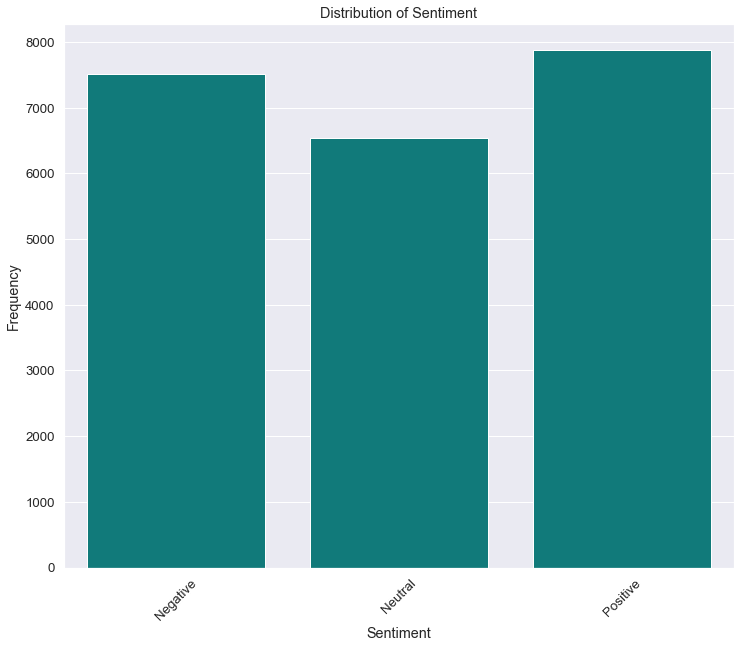

<Figure size 360x360 with 0 Axes>

In [46]:
sentiment_plot = sns.countplot(preprocess_review['sentiment'], color='darkcyan')
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.xticks(rotation = 45)
plt.figure(figsize=(5,5))
sentiment_plot.set(xlabel = 'Sentiment', ylabel = 'Frequency', title='Distribution of Sentiment' )

In [47]:
# this thumbsupcount shows how relevant the text to correaponding reviewers
preprocess_review.thumbsupcount.value_counts()

0       16333
1        1930
2         711
3         426
4         267
        ...  
358         1
1034        1
688         1
571         1
1475        1
Name: thumbsupcount, Length: 279, dtype: int64

In [48]:
# grouping how the each ratings with text has been hepful to other fellow
helpful_review = preprocess_review.groupby('score')['thumbsupcount'].sum()
helpful_review

score
1    26751
2    19837
3    37131
4    39102
5    26090
Name: thumbsupcount, dtype: int64

<AxesSubplot:title={'center':'Distribution of helpful reviews based on rating scores of each reviews'}, xlabel='Rating score', ylabel='Frequency'>

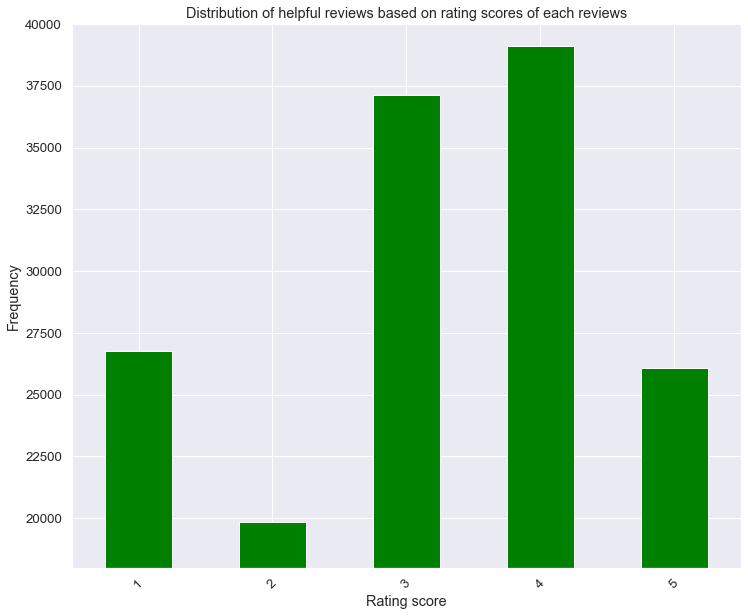

In [49]:
# create a bar plot of the helpful reviews distribution
helpful_review.plot(
kind = 'bar',
color = 'green',
rot = 45,
ylim = (18000, 40000),
title = 'Distribution of helpful reviews based on rating scores of each reviews',
ylabel = 'Frequency',
xlabel= 'Rating score'
)

Let's check if there is any relationship between the sentiment and datetime

In [50]:
preprocess_review['datetime'] = pd.to_datetime(preprocess_review['at'])
preprocess_review['year'] = preprocess_review.datetime.dt.year
preprocess_review['month'] = preprocess_review.datetime.dt.month_name()
preprocess_review['day'] = preprocess_review.datetime.dt.day

preprocess_review.drop('at', axis = 1, inplace = True)
preprocess_review.head()

,reviewid,username,content,score,thumbsupcount,sortorder,appid,sentiment,datetime,year,month,day
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Meditation Relaxing Music Inspiration,Useless and frustrated app in terms of custome...,1,0,most_relevant,com.flutterwave.flybarter,Negative,2022-07-21 09:28:55,2022,July,21
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,mask angel,"Scammers, the lot of them. Don't download this...",1,17,most_relevant,com.flutterwave.flybarter,Negative,2022-06-29 08:59:48,2022,June,29
2,4c55f499-eb1b-4aec-ab8e-858902b60992,Fred Ronald,"My experience hasn't been good,the app keeps l...",1,3,most_relevant,com.flutterwave.flybarter,Negative,2022-07-20 18:57:04,2022,July,20
3,db8cc164-107b-4024-81df-738ec37fd20d,Sweet Love,Very annoying app ever. I signed up account an...,1,8,most_relevant,com.flutterwave.flybarter,Negative,2022-06-04 22:29:25,2022,June,4
4,52b105b4-77e0-4018-87dc-e66c9625790d,Prince Simeon.A,I thought the experience would be an awesome o...,1,1,most_relevant,com.flutterwave.flybarter,Negative,2022-06-03 20:53:11,2022,June,3


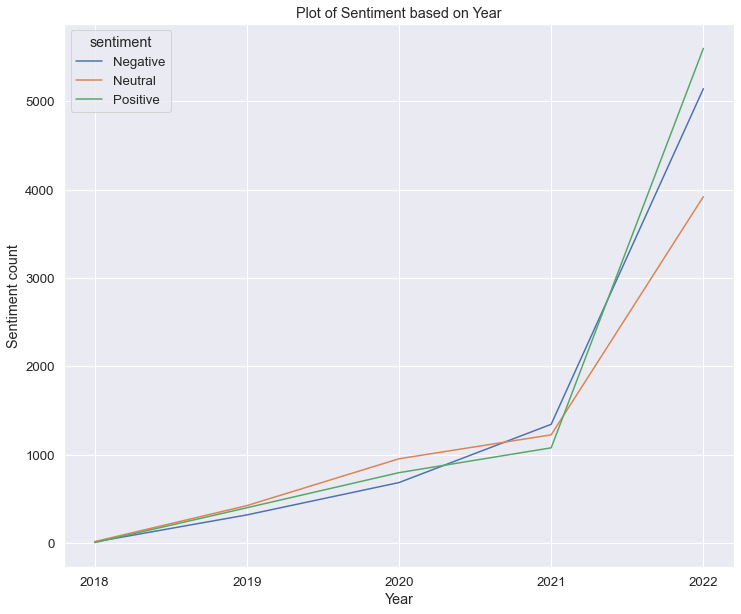

In [35]:
# Plot how Year Vs sentiment
xlim = preprocess_review.year.value_counts(ascending=True).index.to_list()
preprocess_review.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Plot of Sentiment based on Year')
plt.xlabel('Year')
plt.xticks(xlim)
plt.ylabel('Sentiment count')
plt.show()


In [66]:
month_sort = [x.split()[1] for x in preprocess_review.datetime.dt.strftime('%m %B').value_counts().sort_index().index]
month_sentiment  = preprocess_review.groupby(['month','sentiment'])['sentiment'].count().unstack().reindex(month_sort)
month_sentiment

sentiment,Negative,Neutral,Positive
month,,,
January,307,262,257
February,358,391,411
March,562,500,518
April,660,618,581
May,733,614,745
June,1485,1541,1263
July,2143,1358,3009
August,226,245,166
September,246,311,276


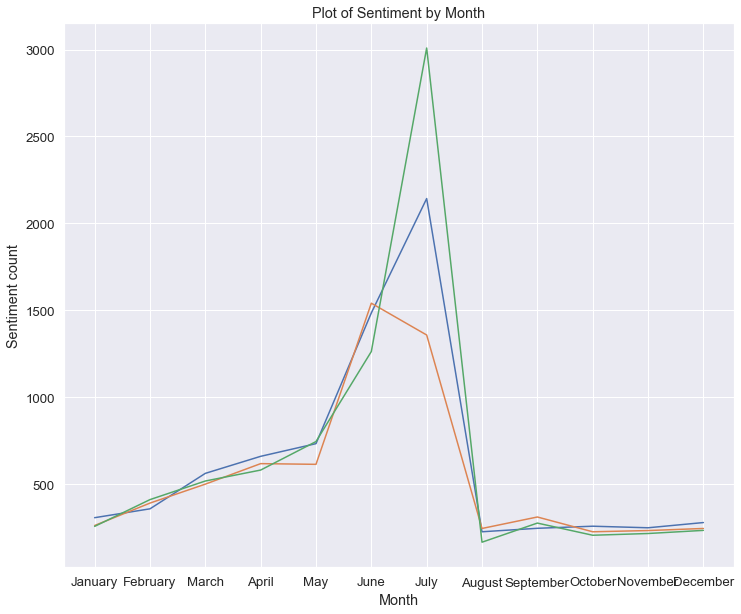

In [72]:
# let check for relationship betwenn month and 
plt.figure(figsize= (12,10))
plt.plot(month_sentiment)
plt.title('Plot of Sentiment by Month')
plt.xlabel('Month')
plt.ylabel('Sentiment count')
plt.show()

<AxesSubplot:xlabel='day'>

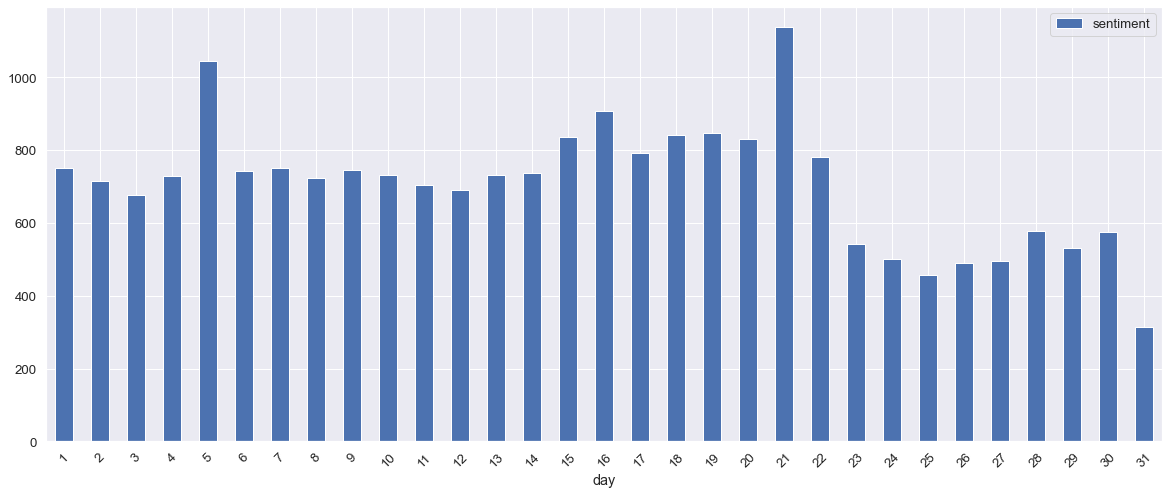

In [86]:
preprocess_review[['day', 'sentiment']].groupby('day').count().plot.bar(figsize=(20,8), rot=45)

In [83]:
preprocess_review['day_of_week'] = preprocess_review.datetime.dt.day_name()
dow_sort = [x.split()[1] for x in preprocess_review.datetime.dt.strftime('%w %A').value_counts().sort_index().index]
dow_sort

['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

<AxesSubplot:xlabel='day_of_week'>

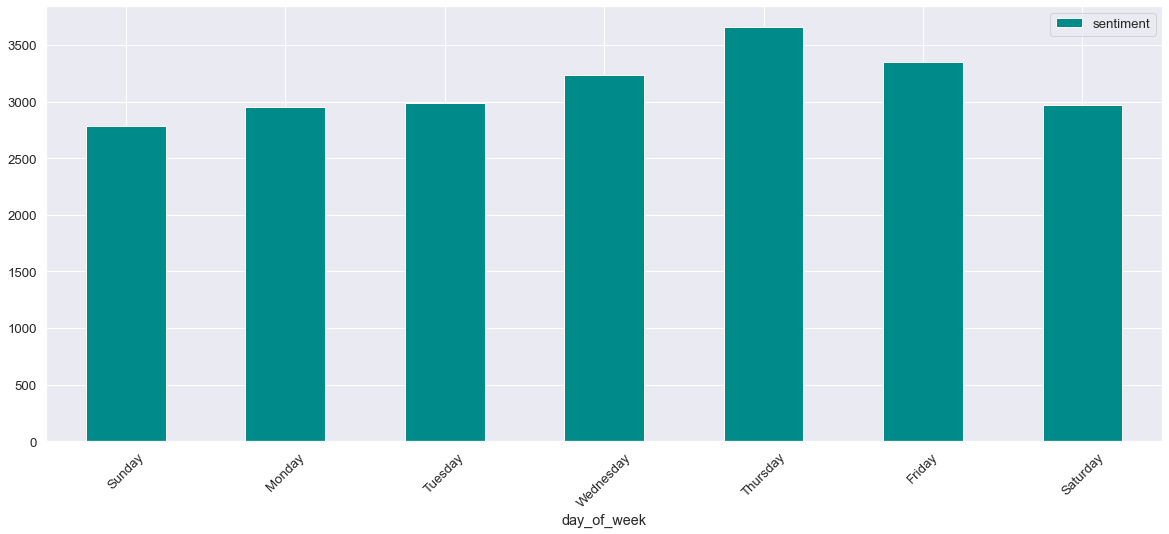

In [89]:
preprocess_review[['day_of_week', 'sentiment']].groupby('day_of_week').count().reindex(dow_sort).plot.bar(figsize=(20,8), rot=45, color = 'darkcyan')

### Text Preprocessing
<li>Data preprocessing is the phase of preparing raw data to make it suitable for a machine learning model. For NLP, that includes expansion contraction text, text cleaning, stopwords removal, stemming and lemmatization </li>

<li>Text cleaning steps vary according to the type of data and the required task. Generally, the string is converted to lowercase and punctuation is removed before text gets tokenized. Tokenization is the process of splitting a string into a list of strings (or “tokens”). </li>

In [92]:
# remove unnecessary columns
process_reviews=preprocess_review.drop(['username','sortorder'], axis=1)
# create a copy 
clean_reviews=process_reviews.copy()

In [103]:
# check the first text
text = clean_reviews.iloc[0, :].content
text

'Useless and frustrated app in terms of customers care. My phone was stolen and I try changing my number which the features keep saying "service is on available at the moment try again later" for the past 3 months. I sent an email 3 months ago with no response and I sent another reminder a week ago, still no response. What\'s the features of customers service doing when you knew customers service are not going to solve your problems? I so hate this app for this weird act'

In [111]:
#lets implement the preprocessing utils for the sample_txt
# preprocess text output
from preprocessing_text_utils import process_text
process_text(text, do_lemmatization=True)

'useless frustrated app term customer care phone stolen try changing number feature keep saying service available moment try later past month sent email month ago response sent another reminder week ago still response feature customer service knew customer service going solve problem hate app weird act'

Length Analysis
<p>It’s important to have a look at the length of the text because it’s an easy calculation that can give a lot of insights. Maybe, for instance, we are lucky enough to discover that one category is systematically longer than another and the length would simply be the only feature needed to build the model. Unfortunately, this won’t be the case as news headlines have similar lengths, but it’s worth a try.</p>

<p>There are several length measures for text data. I will give some examples: </p>

<li>word count: counts the number of tokens in the text (separated by a space) </li>
<li>character count: sum the number of characters of each token</li>
<li>sentence count: count the number of sentences (separated by a period)</li>
<li>average word length: sum of words length divided by the number of words (character count/word count)</li>
<li>average sentence length: sum of sentences length divided by the number of sentences (word count/sentence count) </li>

In [113]:
from preprocessing_text_utils import length_analysis
new_df = clean_reviews.copy()
df = length_analysis(new_df, column = 'content')
df.head()

,reviewid,content,score,thumbsupcount,appid,sentiment,datetime,year,month,day,day_of_week,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,a77c9d14-63ef-47fb-b2ac-99cc82275943,Useless and frustrated app in terms of custome...,1,0,com.flutterwave.flybarter,Negative,2022-07-21 09:28:55,2022,July,21,Thursday,88,386,4,4.386364,22.000000
1,a9fe019a-dbb5-4b85-9d9b-797479fbb7d2,"Scammers, the lot of them. Don't download this...",1,17,com.flutterwave.flybarter,Negative,2022-06-29 08:59:48,2022,June,29,Wednesday,76,353,8,4.644737,9.500000
2,4c55f499-eb1b-4aec-ab8e-858902b60992,"My experience hasn't been good,the app keeps l...",1,3,com.flutterwave.flybarter,Negative,2022-07-20 18:57:04,2022,July,20,Wednesday,88,410,2,4.659091,44.000000
3,db8cc164-107b-4024-81df-738ec37fd20d,Very annoying app ever. I signed up account an...,1,8,com.flutterwave.flybarter,Negative,2022-06-04 22:29:25,2022,June,4,Saturday,76,331,9,4.355263,8.444444
4,52b105b4-77e0-4018-87dc-e66c9625790d,I thought the experience would be an awesome o...,1,1,com.flutterwave.flybarter,Negative,2022-06-03 20:53:11,2022,June,3,Friday,47,213,4,4.531915,11.750000


In [128]:
def histogram_density_plot(df : pd.DataFrame, target : str, var : str):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (20, 8))
    fig.suptitle(f'{target.title()} vs {var.title()}', fontsize=13)
    for i in df[target].unique():
        sns.distplot(df[df[target]==i][var], hist=True, kde=False, 
                    bins=10, hist_kws={"alpha":0.8}, 
                    axlabel="histogram", ax=ax[0])
        sns.distplot(df[df[target]==i][var], hist=False, kde=True, 
                    kde_kws={"shade":True}, axlabel="density",   
                    ax=ax[1])
    ax[0].grid(True)
    ax[0].legend(df[target].unique())
    ax[1].grid(True)
    plt.show()

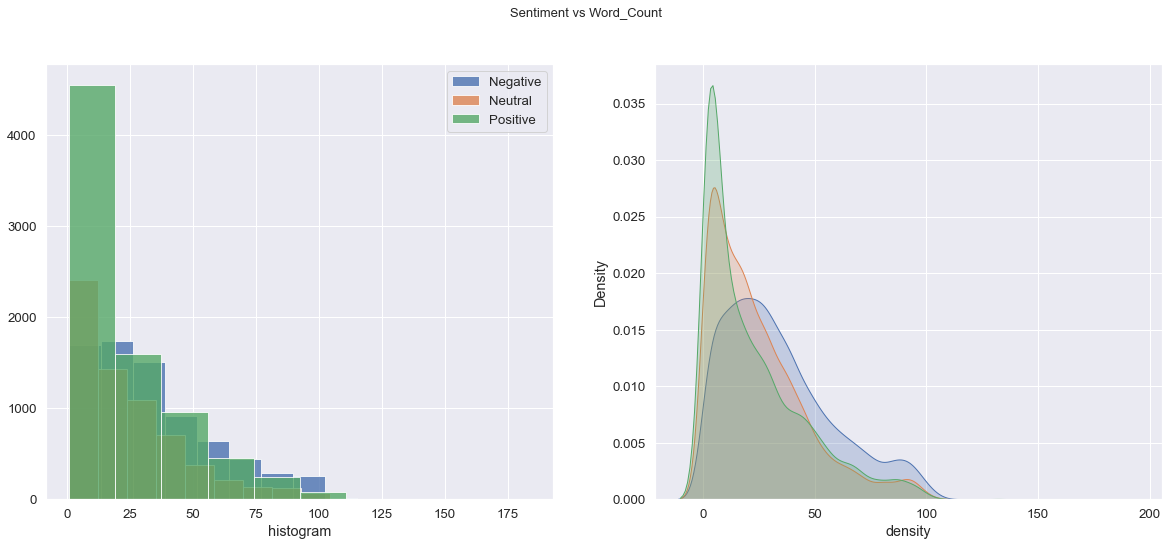

In [129]:
histogram_density_plot(df, 'sentiment', 'word_count')